# Импорт и параметры ("стандартные" значения)

In [18]:
import numpy as np

import math
#from math import factorial

import scipy.integrate
import scipy.special
from scipy.special import kn #Macdonald function
from scipy.special import genlaguerre
from scipy.special import eval_genlaguerre
from scipy.special import expi
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

import torch
import torch.special
from torch.autograd import Function
from torch.special import gammaln
!pip install torchquad
import torchquad
from torchquad import GaussLegendre

from sympy.physics.quantum.spin import WignerD

import matplotlib.pyplot as plt

!pip install PyWavelets
import pywt

from tqdm import tqdm

In [19]:
# Установим dtype и device для PyTorch (можно изменить при необходимости)
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# "Стандартные" значения параметров
m = torch.tensor(1.0, dtype=dtype, device=device) # Масса частицы = масса электрона: 1
sigma = torch.tensor(2590.0, dtype=dtype, device=device) # Продольная ширина волнового пакета в компотоновских длинах волн: 2590 -> 1 nm
pzi = torch.tensor(0.196, dtype=dtype, device=device) # Продольный импульс начального электрона: 0.196 -> 100keV
si = 1 #
li = 1 # Орбитальное квантовое число начального электрона
pzf = torch.tensor(0.19599, dtype=dtype, device=device) # Продольный импульс конечного электрона: 0.19599 -> 99 994.9 eV
sf = 1
lf = 1 # Орбитальное квантовое число конечного электрона

kz = torch.tensor(1.96e-6, dtype=dtype, device=device) # Величина продольного импульса фотона: 1.96e-6 -> 1 eV
kp = torch.tensor(1.96e-7, dtype=dtype, device=device) # Величина поперечного импульса фотона: 1.96e-7 -> 0.1 eV
phi_k = torch.tensor(0.0, dtype=dtype, device=device) # Азимутальный угол импульса фотона: 0

lambda_ = torch.tensor(1.0, dtype=dtype, device=device) # Спиральность фотона: 1
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # Сила со стороны электрического поля на заряд: 7.57e-8 -> 100 MeV/m
# t_C = 1.287e-21 s
# lambda_C = 3.86e-13 m
t_in = torch.tensor(2.56e7, dtype=dtype, device=device) # Время начала наблюдения: 2.56e7 t_c = 3.3e-8 s (соответствует расстоянию в 10 мкм при v = c)
t_out = torch.tensor(2.56e10, dtype=dtype, device=device) # Время пролёта ускорителя: 2.56e10 t_c = 3.3e-11 s (соответствует расстоянию в 1 см при v = c)
# H_c = 4.41e9 T
HtoHc = torch.tensor(2.27e-10, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
# 1 / rho_H соответствует импульсу 7.53e-6 или 3.85 eV
q = torch.tensor(7.297e-3).sqrt().to(dtype=dtype, device=device) # Величина заряда частицы: 7.297e-3 -> q_e
sign = torch.tensor(-1.0, dtype=dtype, device=device) # Знак заряда частицы

kp_max = torch.tensor(1e-4, dtype=dtype, device=device) # Верхний предел интегрирования по величине поперечного импульса фотона: 1e-4 -> 51.1 eV
# kp_max должен быть заметно больше 1 / rho_H
pzf_min = -F0 * t_out # Нижний предел интегрирования по продольному импульсу конечного электрона
# Для F0 = 7.57e-8 = 100 MeV/m и t_out = 2.56e10 = 3.3e-11 s получаем pzf_min = 1.938e3 = 0.99 GeV

# Вспомогательные функции

In [65]:
def factorial(n):
    if isinstance(n, torch.Tensor):
        return torch.exp(torch.special.gammaln(n + 1))
    else:
        n_tensor = torch.tensor(n, dtype=dtype, device=device)
        return torch.exp(torch.special.gammaln(n_tensor + 1))

# Полиномы Лагерра с положительными верхними индексами
def L_mod_1(n, alpha, x):
    # x — torch.tensor
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return 1 + alpha - x
    else:
        L0 = torch.ones_like(x)
        L1 = 1 + alpha - x
        for k in range(2, n + 1):
            Lk = ((2 * k - 1 + alpha - x) * L1 - (k - 1 + alpha) * L0) / k
            L0, L1 = L1, Lk
        return L1

# Полиномы Лагерра с отрицательными верхними индексами
def L_mod(n, alpha, x):
    if alpha > -1:
        return L_mod_1(n,alpha,x)
    else:
        return L_mod_1(n+alpha,-alpha,x)*(-x)**(-alpha)*factorial(n+alpha)/factorial(n)

# Квадрат поперечного импульса
def pp2(s, l, HtoHc, sign):
    l = torch.tensor(l, dtype=dtype, device=device)
    l_abs = torch.abs(l)
    return 2 * HtoHc * (s + l_abs / 2 - sign * l / 2 + 0.5)

# Классическая функция энергии
def En(s, l, pz, t, HtoHc, sign, F0, m):
    return torch.sqrt(m**2 + pp2(s, l, HtoHc, sign) + (pz + F0 * t)**2)

# Классическая продольная траектория
def z(s, l, pz, t, HtoHc, sign, F0, m):
    return (En(s, l, pz, t, HtoHc, sign, F0, m) - En(s, l, pz, 0.0, HtoHc, sign, F0, m)) / F0

# Интеграл от энергии от 0 до t, входящий в действие (здесь интегрируем именно от 0, а не от t_in)
def IntEn(s, l, pz, t, HtoHc, sign, F0, m):
    En_t  = En(s, l, pz, t, HtoHc, sign, F0, m)
    En_0  = En(s, l, pz, 0.0, HtoHc, sign, F0, m)
    En00  = En(s, l, 0.0, 0.0, HtoHc, sign, F0, m)

    term1 = (pz + F0 * t) * En_t - pz * En_0

    num   = pz + F0 * t + En_t
    denom = pz + En_0
    # avoid div by 0 or negative log
    eps = 1e-30
    frac = torch.clamp(torch.abs(num / denom), min=eps)

    term2 = En00**2 * torch.log(frac)

    return (term1 + term2) / (2 * F0)

# Интегральная экспонента
class Exp1Function(Function):
    @staticmethod
    def forward(ctx, input):
        input_np = input.detach().cpu().numpy()
        output_np = scipy.special.exp1(input_np)  # для комплексных значений
        output = torch.from_numpy(np.array(output_np)).to(input.device).type_as(input)
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = -torch.exp(-input) / input
        return grad_output * grad_input

def exp1(x: torch.Tensor) -> torch.Tensor:
    return Exp1Function.apply(x)

# Интеграл по времени от t_in до бесконечности в приближении F0 * t >> pzi, pzf
def K(kp, pzi, pzf, t_in):
    kz = pzi - pzf
    dpz = pzi + pzf
    phase = -1j / (2 * F0) * (torch.sqrt(kp ** 2 + kz ** 2) - kz) * dpz
    arg = -1j * (torch.sqrt(kp ** 2 + kz ** 2) - kz + 1j * 1e-40) * (t_in + dpz / (2 * F0))
    return torch.exp(phase) * exp1(arg)

# интеграл по времени от t_in до t_out
def Kprime(kp, pzi, pzf, t_in, t_out):
    return K(kp, pzi, pzf, t_in) - K(kp, pzi, pzf, t_out)

# Интеграл по поперечной координате
def Ffun(si, li, sf, lf, y):
    sf_lf_fact = factorial(sf + lf)
    si_fact = factorial(si)

    exponent = 3*(si - sf) + 2*li - lf + 2
    y_power = y**(2*(si - sf) + li - lf)

    y_sq = y**2
    L1 = L_mod(sf + lf, (si - sf + li - lf), y_sq / torch.tensor(8, dtype=dtype, device=device))
    L2 = L_mod(sf, (si - sf), y_sq / torch.tensor(8, dtype=dtype, device=device))

    exp_term = torch.exp(-y_sq / torch.tensor(8, dtype=dtype, device=device))

    return (sf_lf_fact / si_fact) * (1 / 2**exponent) * y_power * L1 * L2 * exp_term

def Ip1(si, li, sf, lf, y):
    term1 = 2 * Ffun(si, li, sf, lf + 1, y)
    term2 = (si + li) * Ffun(si, li - 1, sf, lf, y)
    return (-1j) * torch.sqrt(torch.tensor(2.0, device=device)) * (term1 + term2)

def Im1(si, li, sf, lf, y):
    term1 = 2 * Ffun(si, li + 1, sf, lf, y)
    term2 = (sf + lf) * Ffun(si, li, sf, lf - 1, y)
    return (-1j) * torch.sqrt(torch.tensor(2.0, device=device)) * (term1 + term2)

# Регуляризация
eps = torch.tensor(1e-30)

# Члены суммы по проекциям спина фотона на ось z в S_fi
def TT_wide(si, li, pzi, sf, lf, pzf, kp, y, tin, tout):
    kz = pzi - pzf
    omega = torch.sqrt(kp**2 + kz**2)

    tint1 = Kprime(kp, pzi, pzf, tin, tout) / F0
    denominator = 1j * (omega - kz + 1j * eps)
    tint0 = (2 * torch.exp(1j * (omega - kz) * tin)) / denominator - \
            (2 * torch.exp(1j * (omega - kz) * tout)) / denominator

    term1 = Im1(si, li, sf, lf, y) * tint1
    term2 = rho_H * Ffun(si, li, sf, lf, y) * tint0
    term3 = Ip1(si, li, sf, lf, y) * tint1

    return torch.stack([term1, term2, term3])

def wigner_d_matrix_j1_torch(sigma_pol: int, lambda_val: int, beta: torch.Tensor) -> torch.Tensor:

    # Убедимся, что beta является тензором и на правильном устройстве
    if not isinstance(beta, torch.Tensor):
        raise TypeError("beta must be a torch.Tensor")

    # Определение dtype и device из beta
    dtype = beta.dtype
    device = beta.device

    cos_beta = torch.cos(beta)
    sin_beta = torch.sin(beta)
    sqrt_2 = torch.sqrt(torch.tensor(2.0, dtype=dtype, device=device))

    # d^1_{m'm}(beta)
    # Используем сложную структуру if/elif/else для охвата всех 9 элементов матрицы.
    # Это позволяет избежать создания большой таблицы поиска и делает логику явной.

    if sigma_pol == 1:
        if lambda_val == 1:
            return (1 + cos_beta) / 2
        elif lambda_val == -1:
            return (1 - cos_beta) / 2
    elif sigma_pol == 0:
        if lambda_val == 1:
            return sin_beta / sqrt_2
        elif lambda_val == -1:
            return -sin_beta / sqrt_2
    elif sigma_pol == -1:
        if lambda_val == 1:
            return (1 - cos_beta) / 2
        elif lambda_val == -1:
            return (1 + cos_beta) / 2

    # Если индексы sigma_pol или lambda_val выходят за пределы [-1, 0, 1]
    raise ValueError(f"Недопустимые индексы для j=1 d-матрицы: sigma_pol={sigma_pol}, lambda_val={lambda_val}. Они должны быть -1, 0 или 1.")


# Матричный элемент в приближении широкого пакета
def Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out):
    # Ensure all inputs are tensors and on the correct device
    # Convert scalar inputs to tensors if they aren't already

    si_t = torch.tensor(si, dtype=dtype, device=device) if not isinstance(si, torch.Tensor) else si.clone().detach()
    li_t = torch.tensor(li, dtype=dtype, device=device) if not isinstance(li, torch.Tensor) else li.clone().detach()
    sf_t = torch.tensor(sf, dtype=dtype, device=device) if not isinstance(sf, torch.Tensor) else sf.clone().detach()
    lf_t = torch.tensor(lf, dtype=dtype, device=device) if not isinstance(lf, torch.Tensor) else lf.clone().detach()
    lambda_t = torch.tensor(lambda_, dtype=dtype, device=device) if not isinstance(lambda_, torch.Tensor) else lambda_.clone().detach()
    # Pre-calculate common terms for efficiency
    pzi_minus_pzf = pzi - pzf
    kp_sq_plus_pzm_sq = kp**2 + pzi_minus_pzf**2

    sqrt1 = torch.sqrt((2**(torch.abs(li_t) + 1)) / (torch.pi * rho_H**2) * factorial(si_t) / factorial(si_t + li_t))
    sqrt2 = torch.sqrt((2**(torch.abs(lf_t) + 1)) / (torch.pi * rho_H**2) * factorial(sf_t) / factorial(sf_t + lf_t))

    photon_norm = 1 / torch.sqrt(2 * torch.sqrt(kp_sq_plus_pzm_sq))
    # Общий префактор
    prefactor = -2 * torch.pi * 1j * photon_norm * sqrt1 * sqrt2 * (q * rho_H) / (2 * m)
    exp_term = torch.exp(1j * (li_t - lf_t) * phi_k)


    # Второй член в разложении разности координат
    z_exp_factor = torch.exp(-(pzi - En(si, li, pzi, 0, HtoHc, sign, F0, m) - pzf + En(sf, lf, pzf, 0, HtoHc, sign, F0, m))**2 / F0**2 / (4 * sigma**2))


    # Вычисление суммы

    total_sum = torch.zeros_like(kp, dtype=torch.complex128, device=device)
    # Calculate the angle for WignerD
    angle_for_wigner_d = torch.atan2(kp, pzi_minus_pzf)
    # Convert lambda_ to int for wigner_d_matrix_j1_torch
    lambda_int = int(lambda_t.item()) # Use .item() to get Python scalar from 0-dim tensor
    for sigma_pol in range(-1, 2):  # sigma_pol = -1, 0, 1
        i_power = (1j)**(sigma_pol - li_t + lf_t)
        # Get the Wigner D value using the new PyTorch function
        wigner_d_val = wigner_d_matrix_j1_torch(sigma_pol, lambda_int, angle_for_wigner_d)
        # Get the corresponding element from TT
        # Ensure si, li, sf, lf are passed as Python ints to TT_wide's internal functions
        tt_elements = TT_wide(int(si_t.item()), int(li_t.item()), pzi, int(sf_t.item()), int(lf_t.item()), pzf, kp, kp * rho_H, t_in, t_out)
        tt_element = tt_elements[sigma_pol + 1]
        # Add to the sum
        total_sum += i_power * wigner_d_val * tt_element
    result = prefactor * exp_term * total_sum * z_exp_factor
    return result

In [64]:
pzf = pzi + sigma * F0 / 1000
lf = li
print((pzi - En(si, li, pzi, 0, HtoHc, sign, F0, m) - pzf + En(sf, lf, pzf, 0, HtoHc, sign, F0, m))**2 / F0**2 / (4 * 1**2))
print(si, li, pzi, sf, lf, pzf)
print(pzi, En(si, li, pzi, 0, HtoHc, sign, F0, m), pzf, En(sf, lf, pzf, 0, HtoHc, sign, F0, m))
print(torch.exp(-(pzi - En(si, li, pzi, 0, HtoHc, sign, F0, m) - pzf + En(sf, lf, pzf, 0, HtoHc, sign, F0, m))**2 / F0**2 / (4 * 1**2)))

tensor(1.6757, dtype=torch.float64)
1 1 tensor(0.0010, dtype=torch.float64) 1 1 tensor(0.0010, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64) tensor(2.4495, dtype=torch.float64) tensor(0.0010, dtype=torch.float64) tensor(2.4495, dtype=torch.float64)
tensor(0.1872, dtype=torch.float64)


# Вероятность и интенсивность излучения

In [21]:
# Функция для сглаживания быстро осциллирующих функций (выдаёт "среднее значение")
def apply_savgol_filter_to_tensor(data_tensor, sigma):
    data_np = data_tensor.clone().detach().cpu().numpy()
    smoothed_np = gaussian_filter1d(data_np, sigma=sigma)
    return torch.as_tensor(smoothed_np, dtype=data_tensor.dtype, device=data_tensor.device)

def smooth_wavelet(data, wavelet='sym4', level=3, sigma=1.0):
    log_data = np.log10(data)

    # Вейвлет-фильтрация
    coeffs = pywt.wavedec(log_data, wavelet, level=level)
    threshold = 0.2 * np.max(np.abs(coeffs[-1]))  # Мягкий порог
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    smoothed_log = pywt.waverec(coeffs, wavelet)

    # Дополнительное Гауссово сглаживание
    smoothed_log = gaussian_filter1d(smoothed_log, sigma=sigma)

    return 10**smoothed_log

In [22]:
# ------------------ S_fi -------------------

# Сглаженный матричный элемент
# Только для визуализации - не использовать в сглаженных вероятностях
def Sfi_wide_sm(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out):
    return apply_savgol_filter_to_tensor(
        Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out), 20)


# ------------------ Intensity -------------------

# Спектральная интенсивность: d^2 I / (d pzf d k_perp)
def spec_int_unpol_wide(si, li, pzi, sf, lf, pzf, kp, t_in, t_out):
    energy_factor = torch.sqrt(kp**2 + (pzi-pzf)**2)
    measure_factor = (2 * torch.pi)**-3
    S_elem2 = kp * (torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, kp, 0, 1, t_in, t_out))**2 +
                   torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, kp, 0, -1, t_in, t_out))**2)
    return 2 * torch.pi * measure_factor * S_elem2 * energy_factor


# ------------------ Differential Probability -------------------

# Сглаженная дифференциальная вероятность: d W / d pzf

def dW_dpzf_pol_wide_sm_old(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        # Используем clone().detach() для входных данных
        x_tensor = x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype, device=device)
        return x_tensor * torch.abs(Sfi_wide_sm(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2

    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result


def dW_dpzf_pol_wide_sm(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        # Используем clone().detach() для входных данных
        x_tensor = x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype, device=device)
        return apply_savgol_filter_to_tensor(x_tensor * torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2, 20)

    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result

# Просуммированная по поляризациям фотона сглаженная дифференциальная вероятность: d W / d pzf
def dW_dpzf_unpol_wide_sm_old(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_sm_old(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + dW_dpzf_pol_wide_sm_old(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)

def dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_sm(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + dW_dpzf_pol_wide_sm(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)

# Несглаженная дифференциальная вероятность: d W / d pzf
def dW_dpzf_pol_wide(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        x_tensor = x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype, device=device)
        return x_tensor * torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2

    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result

# Просуммированная по поляризациям фотона несглаженная дифференциальная вероятность: d W / d pzf
def dW_dpzf_unpol_wide(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + dW_dpzf_pol_wide(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)


# ------------------ Full Probability -------------------

def full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min):
    gl = torchquad.Gaussian()

    def integrand(pzf_batch):  # pzf_batch has shape [N, 1]
        # Распаковать батч:
        pzf_batch = pzf_batch.view(-1)  # теперь [N]

        # Вернуть батч результатов:
        results = torch.stack([
            dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pzf_i.item(), t_in, t_out, kp_max)
            for pzf_i in pzf_batch
        ])
        return results  # shape [N]

    result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[pzf_min, pzi]]) # Верхний предел интегрирования - pzi
    return result

# Графики

## Двойная дифференциальная вероятность $\frac{d W}{d p_z' d k_{\perp}}$

In [23]:
print(si, 10, pzi, sf, 0, pzf, phi_k, lambda_, t_in, t_out)

1 10 tensor(0.1960, dtype=torch.float64) 1 0 tensor(0.1960, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(25600000., dtype=torch.float64) tensor(2.5600e+10, dtype=torch.float64)


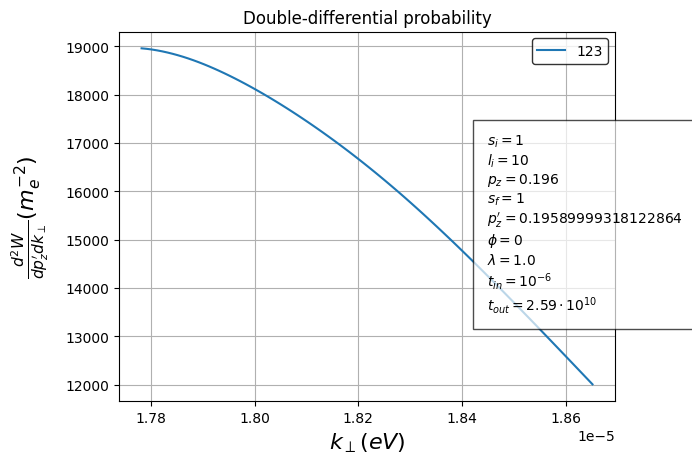

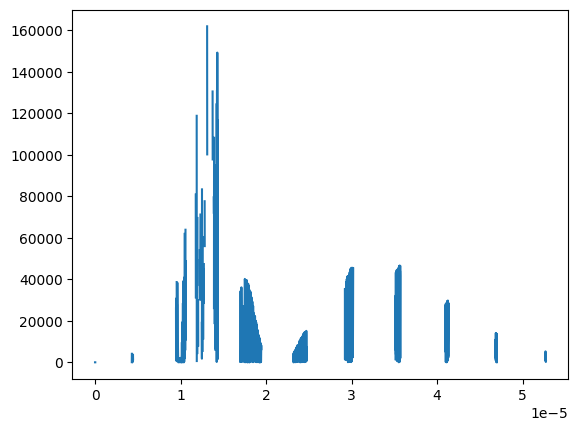

In [24]:
ks = torch.linspace(1e-10,1e-4,10000)
k_ticks = np.linspace(0,1e-4,10)
k_ticks_ev = np.round(np.linspace(0,1e-4 * 0.511 * 10**6, 10), 2)
li = 33
lf = 33
pzf = torch.tensor(0.1959)
t_in = torch.tensor(1.32e8)
t_out = torch.tensor(2.59e10)

plt.figure()
check = ks*abs(Sfi_wide_sm(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2
check2 = apply_savgol_filter_to_tensor(
        ks * torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out))**2, 20)
check3 = apply_savgol_filter_to_tensor(ks*abs(Sfi_wide(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2, 20)
#plt.plot(ks, check, label='123')
#plt.plot(ks, check2, label='123')
plt.plot(ks, check3, label='123')
plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.ylabel(r"$\frac{d^2 W}{d p_z^{\prime} d k_{\perp}} (m_e^{-2})$", rotation=90, fontsize = 16, labelpad=10)
plt.title("Double-differential probability")
plt.grid()
label = f"$s_i={si}$\n$l_i= 10$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$\phi = 0$\n$\lambda={lambda_}$\n$t_{{in}}=10^{{-6}}$\n$t_{{out}}=2.59 \cdot 10^{{10}}$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()
unf = ks*abs(Sfi_wide(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2

plt.figure()
plt.plot(ks, unf)

In [25]:
k123 = torch.tensor(1e-4)
k123*abs(Sfi_wide(si, 100, pzi, sf, 100, pzf, k123, phi_k, lambda_, t_in, t_out))**2

tensor(7.3511e-06, dtype=torch.float64)

In [26]:
ks*abs(Sfi_wide(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2

tensor([2.5451e-11, 2.6230e-05, 2.0674e-04,  ...,        nan,        nan,
               nan], dtype=torch.float64)

## Дифференциальная вероятность $\frac{d W}{d p_z'}$

In [68]:
pzi - sigma * F0 / 10000

tensor(0.0010, dtype=torch.float64)

/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
/tmp/ipython-input-21-1687181392.py:8: RuntimeWarning: divide by zero encountered in log10
  log_data = np.log10(data)


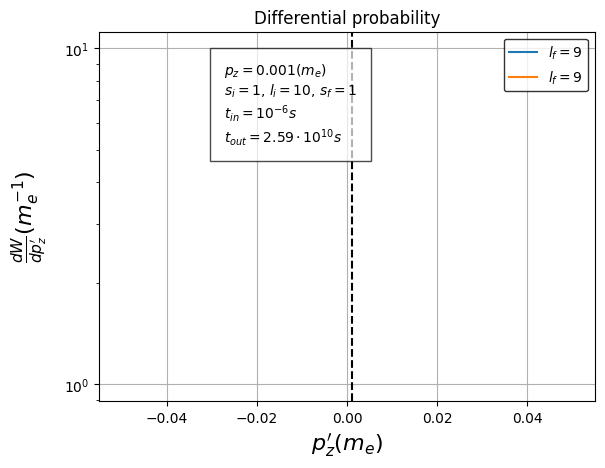

In [69]:
# pzf_max_ = pzi.item()
# pzf_min_ = pzf_min.item()
pzf_min_ = pzi - sigma * F0 / 10000
pzf_max_ = pzi
pzs = np.linspace(pzf_min_, pzf_max_, 100)

pz_ticks = np.round(np.linspace(pzf_min_, pzf_max_, 11), 5)
#pz_ticks_ev = np.round(np.linspace(pzf_min * 0.511 * 10**6, pzf_max * 0.511 * 10**6, 11), 2)

plt.figure()
cmap = plt.get_cmap('magma')
for lf in range(9, 10):
    check = smooth_wavelet([dW_dpzf_unpol_wide_sm(si, 10, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5)
    check2 = smooth_wavelet([dW_dpzf_unpol_wide_sm_old(si, 10, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5)
    plt.plot(pzs, check, label=f'$l_f={lf}$')
    plt.plot(pzs, check2, label=f'$l_f={lf}$')
    plt.yscale("log")
    plt.xlabel("$p_z' (m_e)$", fontsize = 16)
    #plt.xticks(pz_ticks, pz_ticks, rotation=90)
    plt.ylabel(r"$\frac{d W}{d p_z^{\prime}} (m_e^{-1})$", rotation=90, fontsize = 16, labelpad=10)
    plt.title("Differential probability")
    plt.grid()

    label = f"$p_z={pzi} (m_e)$\n$s_i={si}$, $l_i= 10$, $s_f={sf}$\n$t_{{in}}=10^{{-6}} s$\n$t_{{out}}=2.59 \cdot 10^{{10}} s$"
    plt.figtext(0.32, 0.65, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

    legend = plt.legend(frameon=True)

    # Настроим цвет фона и рамки легенды
    legend.get_frame().set_facecolor('white') # белый фон
    legend.get_frame().set_edgecolor('black') # черная рамка
    legend.get_frame().set_linewidth(1.0) # толщина рамки
# plt.ylim(10**-5, 10**-1)
plt.axvline(x=pzi, color='black', linestyle='--', label=f'$p_z = {pzi}$')
plt.show()

## Полная вероятность

/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


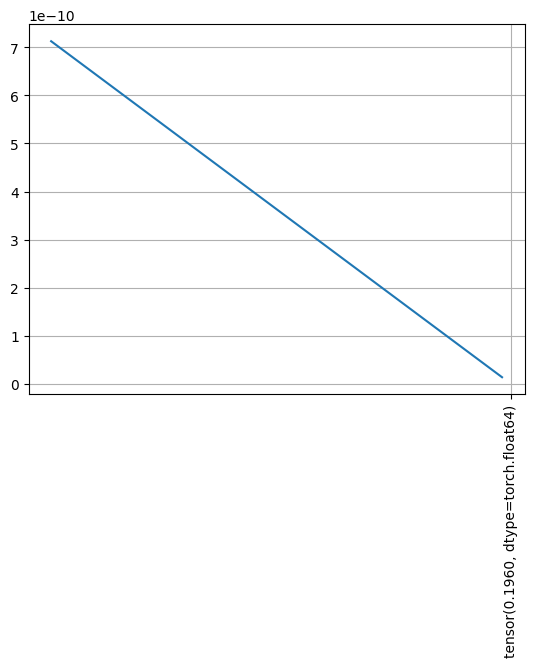

In [28]:
pzs = np.linspace(-10,0,10)
lf = 1

pz_ticks = np.round(np.linspace(-100000,pzi,11), 5)
pz_ticks_ev = np.round(np.linspace(-100000* 0.511 * 10**6,pzi * 0.511 * 10**6, 10), -1)
plt.xticks(pz_ticks, pz_ticks, rotation=90)
plt.plot(pzs, [full_prob(si, li, pzi, sf, lf, 10/F0, t_out, 1e-4,pzmin) for pzmin in pzs])
plt.grid()

Integrating: 100%|██████████| 3/3 [06:52<00:00, 137.64s/it]


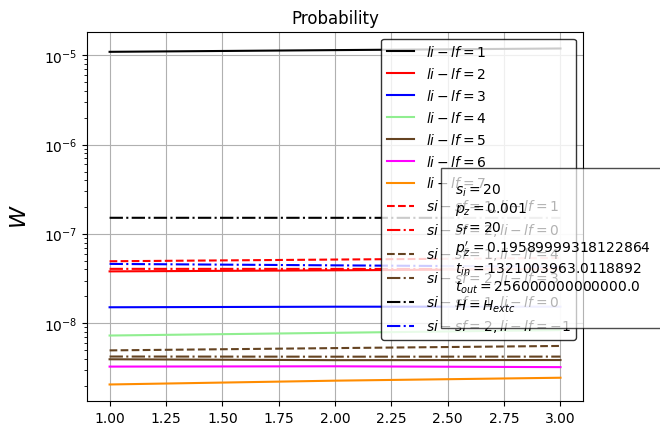

In [29]:
HtoHc = torch.tensor(1, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzf_min = 0
pzi = torch.tensor(1e-3, dtype=dtype, device=device)
pzf_max = pzi

si = 20
li = 1
sf = 20
lf = 1
t_in = 100 / F0
t_out = torch.tensor(2.56e14, dtype=dtype, device=device) # 100 m

full_prob_li_lf_1_Hc = []
full_prob_li_lf_2_Hc = []
full_prob_li_lf_3_Hc = []
full_prob_li_lf_4_Hc = []
full_prob_li_lf_5_Hc = []
full_prob_li_lf_6_Hc = []
full_prob_li_lf_7_Hc = []
full_prob_si_sf_1_li_lf_1_Hc = []
full_prob_si_sf_2_li_lf_0_Hc = []
full_prob_si_sf_1_li_lf_4_Hc = []
full_prob_si_sf_2_li_lf_3_Hc = []
full_prob_si_sf_1_li_lf_0_Hc = []
full_prob_si_sf_2_li_lf_m1_Hc = []

#lf_arr = [i for i in range(1, 80)]
lf_arr = [i for i in range(1, 4)]

HtoHc = torch.tensor(1e-2, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc)

darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_Hc.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_2_Hc.append(full_prob(si, lf + 2, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_3_Hc.append(full_prob(si, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_4_Hc.append(full_prob(si, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_5_Hc.append(full_prob(si, lf + 5, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_6_Hc.append(full_prob(si, lf + 6, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_7_Hc.append(full_prob(si, lf + 7, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_1_Hc.append(full_prob(sf+1, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_0_Hc.append(full_prob(sf+2, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_4_Hc.append(full_prob(sf+1, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_3_Hc.append(full_prob(sf+2, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_0_Hc.append(full_prob(sf+1, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_m1_Hc.append(full_prob(sf+2, lf - 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
plt.plot(lf_arr, full_prob_li_lf_1_Hc, label='$li - lf = 1$', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_2_Hc, label='$li - lf = 2$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_3_Hc, label='$li - lf = 3$', color = 'blue')
plt.plot(lf_arr, full_prob_li_lf_4_Hc, label='$li - lf = 4$', color = 'lightgreen')
plt.plot(lf_arr, full_prob_li_lf_5_Hc, label='$li - lf = 5$', color = darkbrown)
plt.plot(lf_arr, full_prob_li_lf_6_Hc, label='$li - lf = 6$', color = 'magenta')
plt.plot(lf_arr, full_prob_li_lf_7_Hc, label='$li - lf = 7$', color = darkorange)
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_1_Hc, label='$si - sf = 1, li - lf = 1$', color = 'red', linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_0_Hc, label='$si - sf = 2, li - lf = 0$', color = 'red', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_4_Hc, label='$si - sf = 1, li - lf = 4$', color = darkbrown, linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_3_Hc, label='$si - sf = 2, li - lf = 3$', color = darkbrown, linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_0_Hc, label='$si - sf = 1, li - lf = 0$', color = 'black', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_m1_Hc, label='$si - sf = 2, li - lf = -1$', color = 'blue', linestyle = '-.')
#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = H_{{\text{{c}}}}$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

/tmp/ipython-input-30-827691259.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pzmin_arr = [torch.tensor(0), torch.tensor(pzi - 1e-3), torch.tensor(pzi - 2e-5)]
Integrating: 100%|██████████| 5/5 [02:42<00:00, 32.43s/it]


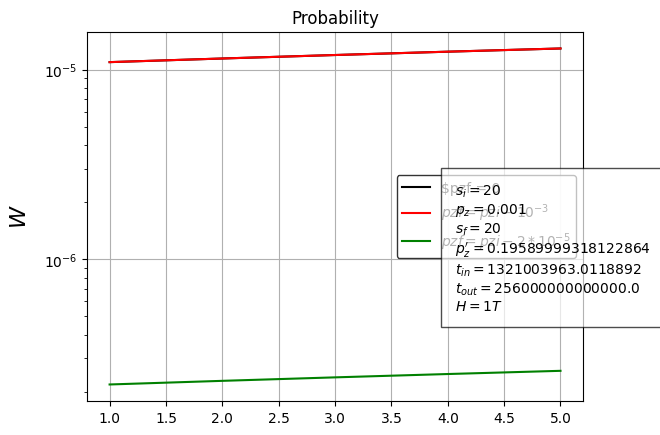

In [30]:
full_prob_li_lf_1_pzmin1 = []
full_prob_li_lf_1_pzmin2 = []
full_prob_li_lf_1_pzmin3 = []

pzmin_arr = [torch.tensor(0), torch.tensor(pzi - 1e-3), torch.tensor(pzi - 2e-5)]


lf_arr = [i for i in range(1, 6)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_pzmin1.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzmin_arr[0]))
    full_prob_li_lf_1_pzmin2.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzmin_arr[1]))
    full_prob_li_lf_1_pzmin3.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzmin_arr[2]))
plt.plot(lf_arr, full_prob_li_lf_1_pzmin1, label='$pzf = 0', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_1_pzmin2, label='$pzf = pzi - 10^{{-3}}$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_1_pzmin3, label='$pzf = pzi - 2 * 10^{{-5}}$', color = 'green')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = 1 T$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [31]:
pzmin_arr = [torch.tensor(0), torch.tensor(pzi - 1e-3), torch.tensor(pzi - 2e-5)]
print(pzmin_arr[1])

tensor(0., dtype=torch.float64)


/tmp/ipython-input-31-2451456664.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pzmin_arr = [torch.tensor(0), torch.tensor(pzi - 1e-3), torch.tensor(pzi - 2e-5)]


Integrating: 100%|██████████| 14/14 [00:59<00:00,  4.25s/it]


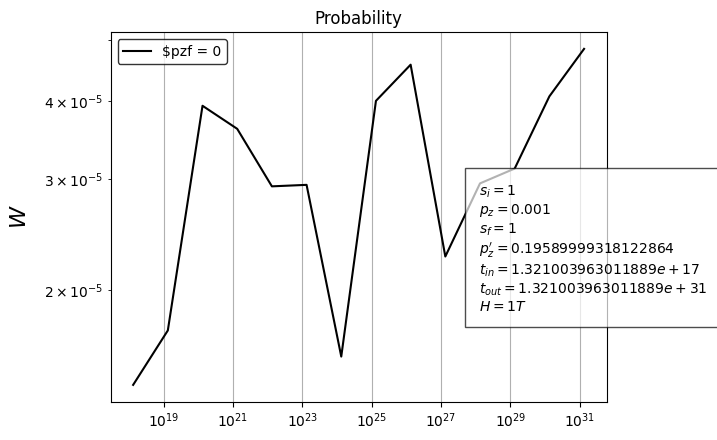

In [32]:
HtoHc = torch.tensor(1, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-16, dtype=dtype, device=device) # 1 V / m
pzf_min = 0

si = 1
li = 1
sf = 1
lf = 1
t_in = 100 / F0
t_out = 2 * t_in

full_prob_mag = []


lf_arr = [i for i in range(1, 3)]
sf_arr = [i for i in range(1, 10)]
t_out_arr = [t_in * 10**i for i in range(1, 15)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for t_out in tqdm(t_out_arr, desc="Integrating", colour="green"):
    full_prob_mag.append(full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))

# plt.plot(lf_arr, full_prob_mag, label='$pzf = 0', color = 'black')
plt.plot(t_out_arr, full_prob_mag, label='$pzf = 0', color = 'black')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = 1 T$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [33]:
print(full_prob(si, li, pzi, sf, lf, t_in, 10000 * t_in, kp_max, pzf_min))

tensor(3.6114e-05, dtype=torch.float64)


Integrating: 100%|██████████| 9/9 [00:40<00:00,  4.55s/it]


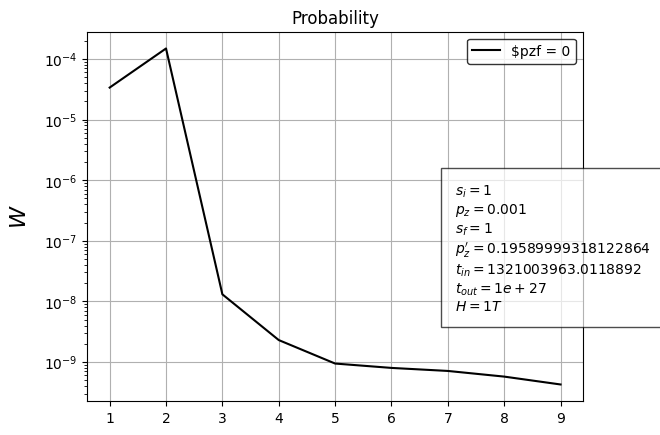

In [34]:
HtoHc = torch.tensor(1, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzf_min = 0

si = 1
li = 1
sf = 1
lf = 1
t_in = 100 / F0
t_out = 1e27

full_prob_mag = []


lf_arr = [i for i in range(1, 10)]
sf_arr = [i for i in range(1, 10)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(sf_arr, desc="Integrating", colour="green"):
    full_prob_mag.append(full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))

plt.plot(lf_arr, full_prob_mag, label='$pzf = 0', color = 'black')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = 1 T$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()